# E-commerce Business Analytics

This notebook analyses sales data from an e-commerce platform and produces actionable business insights across four dimensions: revenue performance, product mix, geographic distribution, and customer experience.

---

## Table of Contents

1. [Business Objectives](#1-business-objectives)
2. [Data Loading and Configuration](#2-data-loading-and-configuration)
3. [Data Preparation and Transformation](#3-data-preparation-and-transformation)
4. [Business Metrics Calculation](#4-business-metrics-calculation)
   - [4a. Revenue Performance](#4a-revenue-performance)
   - [4b. Product Category Analysis](#4b-product-category-analysis)
   - [4c. Geographic Performance](#4c-geographic-performance)
   - [4d. Customer Experience](#4d-customer-experience)
5. [Summary of Observations](#5-summary-of-observations)

## 1. Business Objectives

This analysis addresses the following questions for the selected analysis period:

| # | Business Question |
|---|---|
| 1 | How did total revenue, order volume, and average order value compare year-over-year? |
| 2 | What is the month-over-month revenue growth trend within the analysis year? |
| 3 | Which product categories generate the most revenue and what share of total revenue do they represent? |
| 4 | Which US states drive the most revenue and how does order value vary by region? |
| 5 | How does delivery speed relate to customer satisfaction (review scores)? |

---

### Data Dictionary

| Column | Table | Description |
|---|---|---|
| `order_id` | orders, order_items, reviews | Unique identifier for each customer order |
| `customer_id` | orders, customers | Identifier linking an order to a customer record |
| `order_status` | orders | Lifecycle stage: `delivered`, `shipped`, `canceled`, `processing`, `pending`, `returned` |
| `order_purchase_timestamp` | orders | Date and time the customer placed the order |
| `order_delivered_customer_date` | orders | Date and time the order was delivered to the customer |
| `price` | order_items | Item price paid by the customer (USD) |
| `freight_value` | order_items | Shipping cost for the item (USD) |
| `product_category_name` | products | Category the product belongs to (13 categories) |
| `customer_state` | customers | US state abbreviation of the customer's address |
| `review_score` | order_reviews | Customer satisfaction rating on a 1-5 scale |
| `delivery_days` | derived | Calendar days between purchase timestamp and customer delivery |
| `purchase_year` | derived | Year extracted from `order_purchase_timestamp` |
| `purchase_month` | derived | Month (1-12) extracted from `order_purchase_timestamp` |

## 2. Data Loading and Configuration

All analysis parameters are defined in a single configuration cell. Adjust `ANALYSIS_YEAR`, `COMPARISON_YEAR`, and optionally `ANALYSIS_MONTH` to change the scope of the analysis without modifying any other code.

In [1]:
# ── Analysis Configuration ───────────────────────────────────────────────────
# Modify these values to change the analysis period.

DATA_PATH       = 'ecommerce_data/'  # Path to the directory containing CSV files
ANALYSIS_YEAR   = 2023               # Year to analyse
COMPARISON_YEAR = 2022               # Year used for year-over-year comparisons
ANALYSIS_MONTH  = None               # Set to an integer (1-12) to restrict to a single month;
                                     # leave as None for a full-year analysis
ORDER_STATUS    = 'delivered'        # Order status filter applied to all revenue metrics

In [2]:
from data_loader import load_and_process_data
from business_metrics import (
    calculate_revenue_metrics,
    calculate_monthly_revenue,
    calculate_product_metrics,
    calculate_geographic_metrics,
    calculate_delivery_metrics,
    calculate_review_distribution,
    plot_revenue_trend,
    plot_mom_growth,
    plot_category_performance,
    plot_geographic_performance,
    plot_review_distribution,
    plot_delivery_vs_score,
    print_metrics_summary,
)

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load and process all six CSV files.
# `loader` provides access to individual raw tables via loader.orders, loader.products, etc.
# `processed` is the fully merged dataset with derived columns.

loader, processed = load_and_process_data(DATA_PATH)

print(f'Dataset loaded: {len(processed):,} rows across {processed["order_id"].nunique():,} unique orders')

Dataset loaded: 16,047 rows across 10,000 unique orders


## 3. Data Preparation and Transformation

We create two filtered datasets from the processed data:
- `sales_current` - orders in `ANALYSIS_YEAR` (with optional month filter) matching `ORDER_STATUS`
- `sales_comparison` - orders in `COMPARISON_YEAR` matching `ORDER_STATUS`

All downstream calculations operate on these two datasets.

In [4]:
sales_current = loader.create_sales_dataset(
    year_filter=ANALYSIS_YEAR,
    month_filter=ANALYSIS_MONTH,
    status_filter=ORDER_STATUS,
)

sales_comparison = loader.create_sales_dataset(
    year_filter=COMPARISON_YEAR,
    month_filter=ANALYSIS_MONTH,
    status_filter=ORDER_STATUS,
)

period_label = (
    f'{ANALYSIS_YEAR} (month {ANALYSIS_MONTH})'
    if ANALYSIS_MONTH
    else str(ANALYSIS_YEAR)
)

print(f'Analysis period : {period_label}')
print(f'  Orders        : {sales_current["order_id"].nunique():,}')
print(f'  Line items    : {len(sales_current):,}')
print(f'Comparison year : {COMPARISON_YEAR}')
print(f'  Orders        : {sales_comparison["order_id"].nunique():,}')
print(f'  Line items    : {len(sales_comparison):,}')

Analysis period : 2023
  Orders        : 4,635
  Line items    : 7,448
Comparison year : 2022
  Orders        : 4,749
  Line items    : 7,641


In [5]:
# Preview the schema used by all downstream functions.
sales_current.head(3)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,product_category_name,customer_state,customer_city,review_score,purchase_year,purchase_month,delivery_days
0,ord_5fa044951857e02fd1347b47,1,prod_9b6f1793388ae983f852d189,111.91,9.50,cust_2d36e4b647be13c15df550af,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,grocery_gourmet_food,TN,Knoxville,5.0,2023,4,6.0
1,ord_5fa044951857e02fd1347b47,2,prod_c7b5997a4d0061a9f50e874c,878.42,77.50,cust_2d36e4b647be13c15df550af,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,electronics,TN,Knoxville,5.0,2023,4,6.0
2,ord_43b53981d951f855231d09ec,1,prod_496e129d773e9587e8ddc065,749.83,13.94,cust_e670ce607e4f6aa14935ece0,delivered,2023-12-10 05:13:58.249202,2023-12-19 09:13:58.249202,sports_outdoors,FL,Orlando,5.0,2023,12,9.0


In [6]:
# Confirm order status composition in the analysis year (unfiltered) so that
# the coverage of 'delivered' orders is transparent.
status_dist = (
    loader.orders[loader.orders['order_purchase_timestamp'].dt.year == ANALYSIS_YEAR]
    ['order_status']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .rename('pct_of_orders')
)
print(f'Order status distribution in {ANALYSIS_YEAR}:')
print(status_dist.to_string())

Order status distribution in 2023:
order_status
delivered     93.64
shipped        3.19
canceled       1.29
processing     1.19
pending        0.51
returned       0.18


## 4. Business Metrics Calculation

Each subsection below covers one analytical dimension. All metrics are derived from `sales_current` and `sales_comparison` using the functions in `business_metrics.py`.

### 4a. Revenue Performance

We examine three top-level KPIs — total revenue, total order count, and average order value (AOV) — comparing the analysis year to the prior year. We then drill into monthly revenue trends and month-over-month growth rates.

In [7]:
revenue_metrics = calculate_revenue_metrics(
    current_sales=sales_current,
    comparison_sales=sales_comparison,
    current_year=ANALYSIS_YEAR,
    comparison_year=COMPARISON_YEAR,
)

cy = ANALYSIS_YEAR
py = COMPARISON_YEAR

print(f'Total Revenue    {cy}: ${revenue_metrics[f"total_revenue_{cy}"]:>12,.2f}')
print(f'Total Revenue    {py}: ${revenue_metrics[f"total_revenue_{py}"]:>12,.2f}')
print(f'YoY Growth          : {revenue_metrics["revenue_growth_pct"]:>+12.2f}%')
print()
print(f'Total Orders     {cy}: {revenue_metrics[f"total_orders_{cy}"]:>13,}')
print(f'Total Orders     {py}: {revenue_metrics[f"total_orders_{py}"]:>13,}')
print(f'YoY Growth          : {revenue_metrics["order_growth_pct"]:>+12.2f}%')
print()
print(f'Avg Order Value  {cy}: ${revenue_metrics[f"aov_{cy}"]:>12,.2f}')
print(f'Avg Order Value  {py}: ${revenue_metrics[f"aov_{py}"]:>12,.2f}')
print(f'YoY Growth          : {revenue_metrics["aov_growth_pct"]:>+12.2f}%')

Total Revenue    2023: $3,360,294.74
Total Revenue    2022: $3,445,076.96
YoY Growth          :        -2.46%

Total Orders     2023:         4,635
Total Orders     2022:         4,749
YoY Growth          :        -2.40%

Avg Order Value  2023: $      724.98
Avg Order Value  2022: $      725.43
YoY Growth          :        -0.06%


In [8]:
# Monthly revenue table for the analysis year
monthly_revenue = calculate_monthly_revenue(sales_current)
print(f'Monthly revenue and MoM growth - {ANALYSIS_YEAR}')
print(monthly_revenue.to_string(index=False))

Monthly revenue and MoM growth - 2023
 purchase_month   revenue  mom_growth_pct
              1 284855.48             NaN
              2 276758.54       -2.842473
              3 285618.77        3.201430
              4 253794.62      -11.142177
              5 301347.96       18.736938
              6 289126.72       -4.055524
              7 296209.39        2.449677
              8 286645.60       -3.228726
              9 303793.15        5.982143
             10 259890.15      -14.451610
             11 259518.93       -0.142837
             12 262735.43        1.239409


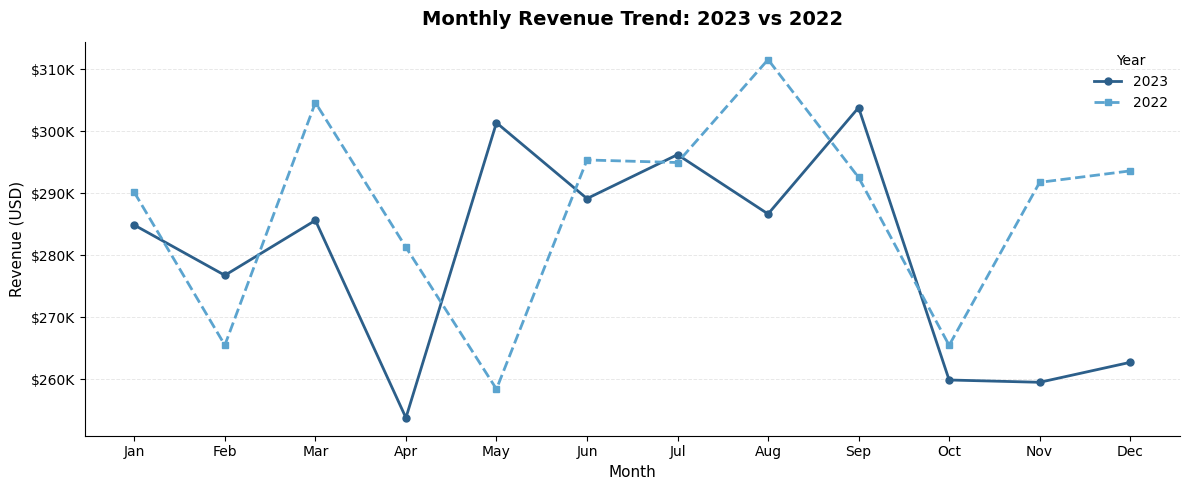

In [9]:
# Line chart: monthly revenue comparison (current year vs comparison year)
fig = plot_revenue_trend(
    current_sales=sales_current,
    comparison_sales=sales_comparison,
    current_year=ANALYSIS_YEAR,
    comparison_year=COMPARISON_YEAR,
)
plt.show()

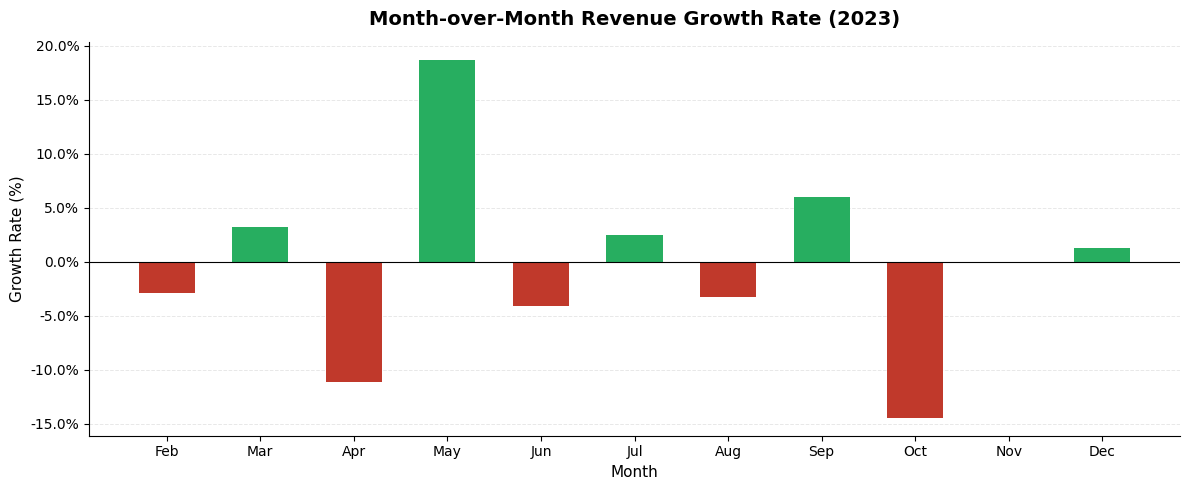

In [10]:
# Bar chart: month-over-month growth rate within the analysis year
fig = plot_mom_growth(sales_current, ANALYSIS_YEAR)
plt.show()

### 4b. Product Category Analysis

We rank all 13 product categories by revenue generated in the analysis year and calculate each category's share of total revenue.

In [11]:
product_metrics = calculate_product_metrics(sales_current)

print(f'Product category revenue breakdown - {ANALYSIS_YEAR}')
print(product_metrics[['product_category_name', 'revenue', 'market_share_pct']].to_string(index=False))

Product category revenue breakdown - 2023
 product_category_name    revenue  market_share_pct
           electronics 1401359.21             41.70
           home_garden  862653.27             25.67
       sports_outdoors  278845.32              8.30
            automotive  247707.10              7.37
clothing_shoes_jewelry  232745.04              6.93
            toys_games   70163.64              2.09
  health_personal_care   65370.27              1.95
tools_home_improvement   54280.33              1.62
  beauty_personal_care   49213.30              1.46
           books_media   38559.08              1.15
  grocery_gourmet_food   26964.36              0.80
         baby_products   25302.54              0.75
          pet_supplies    7131.28              0.21


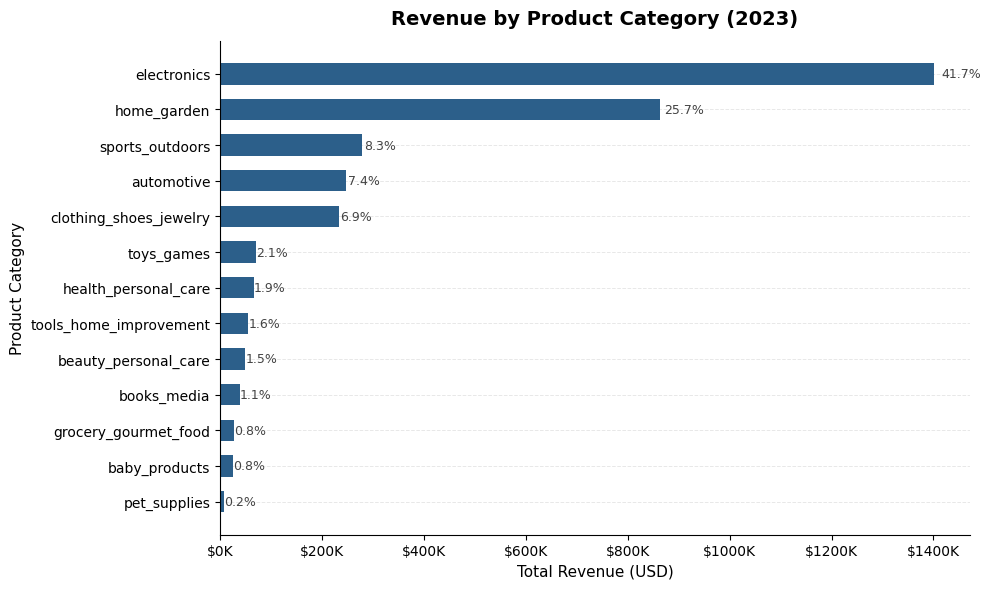

In [12]:
# Horizontal bar chart: revenue by product category with market share labels
fig = plot_category_performance(product_metrics, ANALYSIS_YEAR)
plt.show()

### 4c. Geographic Performance

Revenue, order count, and average order value are aggregated at the US state level. The choropleth map provides a quick visual of revenue concentration across the country.

In [13]:
geo_metrics = calculate_geographic_metrics(sales_current)

print(f'Top 10 states by revenue - {ANALYSIS_YEAR}')
print(geo_metrics.head(10)[['customer_state', 'revenue', 'order_count', 'aov']].to_string(index=False))

Top 10 states by revenue - 2023
customer_state   revenue  order_count    aov
            CA 537880.74          769 699.45
            TX 403303.49          561 718.90
            FL 310195.84          431 719.71
            NY 253111.85          384 659.15
            IL 185930.89          260 715.12
            PA 173260.68          225 770.05
            OH 157619.72          200 788.10
            GA 146414.65          190 770.60
            MI 132325.60          210 630.12
            NC 128314.74          177 724.94


In [14]:
# Interactive choropleth: revenue by US state
fig = plot_geographic_performance(geo_metrics, ANALYSIS_YEAR)
fig.show()

### 4d. Customer Experience

We analyse how customers rate their orders (review scores 1-5) and whether faster delivery correlates with higher satisfaction. Analysis is performed at the order level to avoid double-counting multi-item orders.

In [15]:
delivery_metrics = calculate_delivery_metrics(sales_current)

print(f'Customer experience summary - {ANALYSIS_YEAR}')
print(f'  Average delivery time : {delivery_metrics["avg_delivery_days"]} days')
print(f'  Average review score  : {delivery_metrics["avg_review_score"]} / 5.0')
print()
print('Review score by delivery speed bucket:')
print(delivery_metrics['delivery_bucket_summary'].to_string(index=False))

Customer experience summary - 2023
  Average delivery time : 8.0 days
  Average review score  : 4.1 / 5.0

Review score by delivery speed bucket:
delivery_time  avg_review_score  order_count
     1-3 days          4.193966          332
     4-7 days          4.075063         1727
      8+ days          4.108138         2576


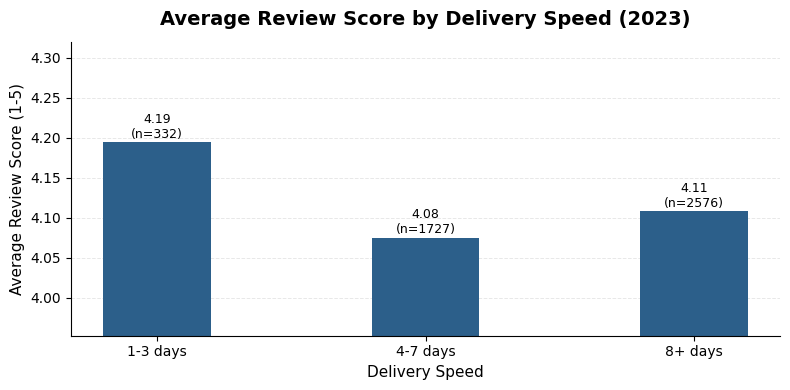

In [16]:
# Bar chart: average review score by delivery speed bucket
fig = plot_delivery_vs_score(delivery_metrics, ANALYSIS_YEAR)
plt.show()

In [17]:
review_dist = calculate_review_distribution(sales_current)

print(f'Review score distribution - {ANALYSIS_YEAR}')
print(review_dist[['review_score', 'pct']].to_string(index=False))

Review score distribution - 2023
 review_score  pct
          1.0  3.5
          2.0  6.9
          3.0 15.4
          4.0 24.3
          5.0 49.9


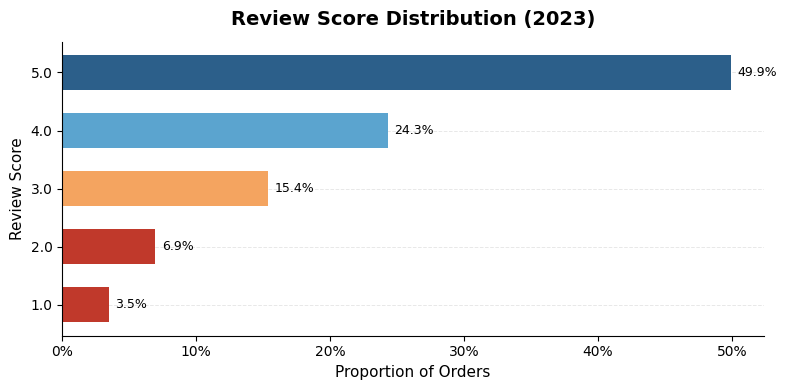

In [18]:
# Horizontal bar chart: proportion of orders at each review score
fig = plot_review_distribution(review_dist, ANALYSIS_YEAR)
plt.show()

## 5. Summary of Observations

The cell below prints a consolidated metrics summary. Interpretations should be drawn from the specific numbers produced when the notebook is run — adjust `ANALYSIS_YEAR` and `COMPARISON_YEAR` at the top of the notebook to change the reporting period.

In [19]:
print_metrics_summary(revenue_metrics, delivery_metrics)

BUSINESS METRICS SUMMARY - 2023

REVENUE PERFORMANCE
  Total Revenue (2023):        $3,360,294.74
  Total Revenue (2022):        $3,445,076.96
  YoY Revenue Growth:                -2.46%

ORDERS
  Total Orders (2023):                4,635
  Total Orders (2022):                4,749
  YoY Order Growth:                  -2.40%

AVERAGE ORDER VALUE
  AOV (2023):                  $      724.98
  AOV (2022):                  $      725.43
  YoY AOV Growth:                    -0.06%

CUSTOMER EXPERIENCE
  Average Review Score:                4.10 / 5.0
  Average Delivery Time:               8.0 days


In [20]:
# Top product categories
top_cat = product_metrics.iloc[0]
print(f'Top revenue category  : {top_cat["product_category_name"]} ({top_cat["market_share_pct"]}% of total revenue)')

# Top state
top_state = geo_metrics.iloc[0]
print(f'Top revenue state     : {top_state["customer_state"]} (${top_state["revenue"]:,.0f})')

# Delivery and satisfaction
print(f'Avg delivery time     : {delivery_metrics["avg_delivery_days"]} days')
print(f'Avg review score      : {delivery_metrics["avg_review_score"]} / 5.0')

Top revenue category  : electronics (41.7% of total revenue)
Top revenue state     : CA ($537,881)
Avg delivery time     : 8.0 days
Avg review score      : 4.1 / 5.0
